<h1 style='text-align: center;'> Non-negative Matrix Factorization Demo Codes at the AGU 2023 </h1>
<h2 style='text-align: center;'> Tao Wen (twen08@syr.edu; Syracuse University)  </h2>

## 0. Import packages and set current directory

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.decomposition import PCA

import os
import time
#import geopandas as gpd

import nmf_modules as nmf # local user-defined functions

# Set working directory
# Replace '../codes/' with the actual path to your folder
# os.chdir('../codes/')

In [2]:
os.getcwd()

'/Users/twen08/Library/CloudStorage/Dropbox/Conferences and Workshop/2023AGU/workshop/agu_workshop_nmf/codes'

## 1. Data Pre-processing

### 1.1 (OPTIONAL) Subset the original dataset

In [ ]:
# Data Pre-processing
# Read the original dataset
us_annual_raw = pd.read_csv("annual_NMF_original.csv")

# Shuffle the dataset and sample 50 rows
us_annual_raw = us_annual_raw.sample(frac=1, replace=False, random_state = 233, ignore_index=True)
us_annual_reduced = us_annual_raw.sample(n=50, replace=False, random_state = 233, ignore_index=True)

# Write the sampled dataset back to the file
us_annual_reduced.to_csv("../output/datasets/annual_NMF_reduced.csv", index=False)

### 1.2 Reformat the dataset

In [3]:
# Load the reduced dataset
us_annual_reduced = pd.read_csv("../output/datasets/annual_NMF_reduced.csv")

# Add row number as sample id
us_annual = us_annual_reduced.assign(sample=np.arange(1, len(us_annual_reduced) + 1))

# Prepare dataset for PCA and NMF
us_annual_pca_nmf = us_annual.filter(like='_Na').dropna().apply(lambda x: x / x.max(), axis=0)

# Save to a pickle and a CSV file
us_annual.to_pickle("../output/datasets/us_annual.pkl")  # Save as pickle
us_annual_pca_nmf.to_csv("../output/datasets/us_annual_pca_nmf.csv", index=False)
us_annual_pca_nmf.to_pickle("../output/datasets/us_annual_pca_nmf.pkl")  # Save as pickle

### 1.3 Map sample locations

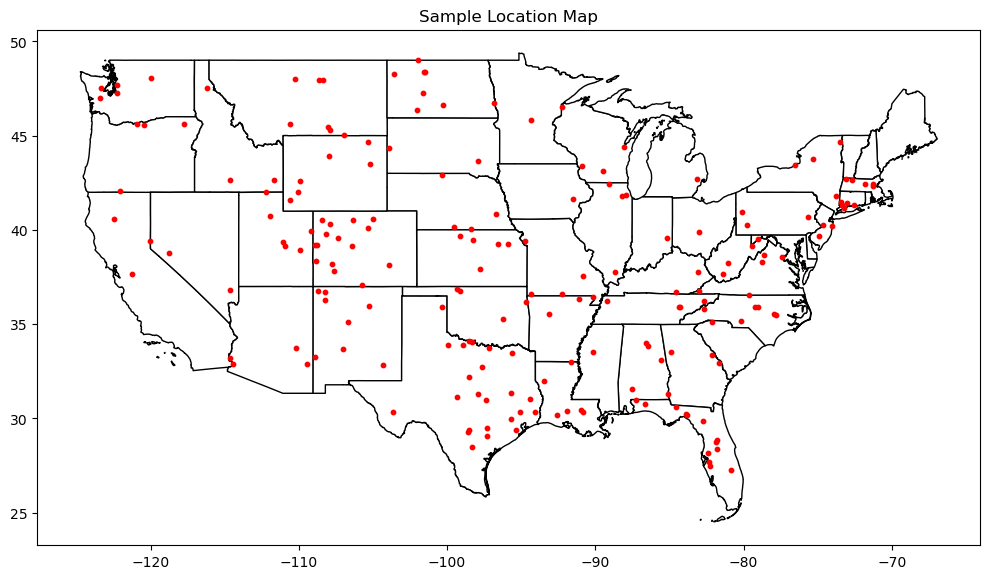

In [4]:
# Read the US state boundaries shapefile
us_states = gpd.read_file("../input/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

# Filter out certain regions
exclude_states = [
    "Alaska", "Puerto Rico", "American Samoa",
    "Commonwealth of the Northern Mariana Islands",
    "Guam", "United States Virgin Islands", "Hawaii"
]
us_states_filtered = us_states[~us_states["NAME"].isin(exclude_states)]

# Read the sampling locations
us_annual_location = gpd.GeoDataFrame(
    us_annual_reduced, 
    geometry=gpd.points_from_xy(us_annual_reduced["dec_lon_va"], us_annual_reduced["dec_lat_va"]), 
    crs="EPSG:4326"
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
us_states_filtered.plot(ax=ax, color='white', edgecolor='black', linestyle='-', linewidth=1)
us_annual_location.plot(ax=ax, color='red', markersize=10)
plt.title('Sample Location Map')
plt.tight_layout()
plt.savefig("../output/figures/Sample_Location_Map.pdf")
plt.show()

## 2. PCA and NMF

### 2.1 Perform PCA to determine the minimum number of components for 95% variability

In [5]:
# Run PCA
pca = PCA()
pca.fit(us_annual_pca_nmf)

PCA()

In [6]:
# Calculate cumulative explained variance
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_var)

[0.49247938 0.81435711 0.90817595 0.98916916 0.99982787 1.        ]


In [7]:
# Determine the number of components for 95% variability
n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
print(f"Number of components for 95% variability: {n_components_95}")

Number of components for 95% variability: 4


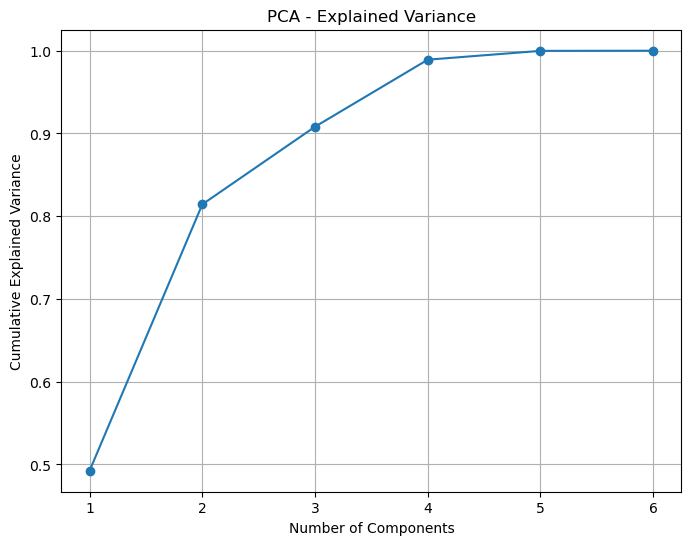

In [8]:
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid()
plt.show()

### 2.2 Perform NMF

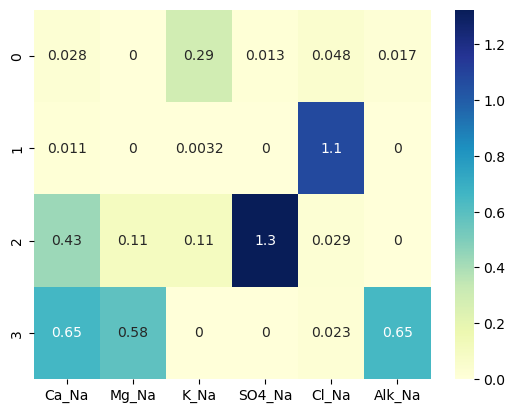

The number of model iteration: 7536
The dimension of matrix W is (200, 4)
The dimension of matrix W is (4, 6)
Execution time: 0.37873101234436035 seconds


In [9]:
# get the start time
st = time.time()

# run NMF once to evaluate the delineated endmember composition
nmf.run_single_model(data_norm_path="../output/datasets/us_annual_pca_nmf.csv",
                     data_synthetic_path="../output/datasets/us_annual_pca_nmf.csv")

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

In [10]:
# get the start time
st = time.time()

# Execute the complete NMF model
nmf.main_run_model(suffix="us_annual",
                   data_norm_path="../output/datasets/us_annual_pca_nmf.csv",
                   data_synthetic_path="../output/datasets/us_annual_pca_nmf.csv")

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

error in seed: 16
error in seed: 1463
error in seed: 1584
Done.
Execution time: 96.252681016922 seconds


## 3. NMF results post-processing

### 3.1 Clean NMF output

In [11]:
# Read in the NMF output
us_annual = pd.read_pickle("../output/datasets/us_annual.pkl")
us_annual_nmf_na_out = pd.read_csv("../output/datasets/nmf_out_4em_Na_us_annual.csv")
us_annual_pca_nmf = pd.read_pickle("../output/datasets/us_annual_pca_nmf.pkl")

# Perform data processing steps similar to R code
# Adding a 'sample' column to us_annual_pca_nmf
us_annual_pca_nmf['sample'] = us_annual_pca_nmf.index + 1

# Arrange us_annual_nmf_na_out by 'sample'
us_annual_nmf_na_out.sort_values(by='sample', inplace=True)

# Merging NMF output and input dataframes based on 'sample'
us_annual_nmf_proc_na = pd.merge(us_annual_pca_nmf, us_annual_nmf_na_out, on='sample', how='outer')

# Calculate error between modeled ratios and measured ratios
us_annual_nmf_proc_na['error'] = ((us_annual_nmf_proc_na['Ca_Na'] - us_annual_nmf_proc_na['Ca_mod'])**2 +
                                   (us_annual_nmf_proc_na['Mg_Na'] - us_annual_nmf_proc_na['Mg_mod'])**2 +
                                   (us_annual_nmf_proc_na['K_Na'] - us_annual_nmf_proc_na['K_mod'])**2 +
                                   (us_annual_nmf_proc_na['SO4_Na'] - us_annual_nmf_proc_na['SO4_mod'])**2 +
                                   (us_annual_nmf_proc_na['Cl_Na'] - us_annual_nmf_proc_na['Cl_mod'])**2 +
                                   (us_annual_nmf_proc_na['Alk_Na'] - us_annual_nmf_proc_na['Alk_mod'])**2)

# Group by 'sample' and nest the data
us_annual_nmf_clean_na = us_annual_nmf_proc_na.groupby('sample').apply(lambda x: x.drop(columns='sample') \
                                                                      .to_dict(orient='records')).reset_index(name='data')

max_ratio = us_annual.filter(like='_Na').agg('max', axis=0, skipna=True)

# Count # of NMF solution for each sample
us_annual_nmf_clean_na['n'] = us_annual_nmf_clean_na.apply(lambda x: len(x['data']), axis=1)

# Derived error at 10% quantitle for each sampple
us_annual_nmf_clean_na['ref'] = us_annual_nmf_clean_na.apply(lambda x: pd.DataFrame(x['data'])['error'].quantile(q=0.1), axis=1)

# Filter data rows by the ref error value for each sample
us_annual_nmf_clean_na['filtered'] = us_annual_nmf_clean_na.apply(lambda x: pd.DataFrame(x['data']) \
                                                                  .loc[pd.DataFrame(x['data'])['error']<x['ref']], axis=1)

# Count # of NMF solution for each sample with error samller than the ref value
us_annual_nmf_clean_na['new_n'] = us_annual_nmf_clean_na.apply(lambda x: len(x['filtered']), axis=1)

# Calculate mean and sd contribution of each endmember to each sample
us_annual_nmf_clean_na['X_cl'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['em1'].mean(), axis=1)
us_annual_nmf_clean_na['X_cl_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['em1'].std(), axis=1) 
us_annual_nmf_clean_na['X_so4'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['em2'].mean(), axis=1)
us_annual_nmf_clean_na['X_so4_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['em2'].std(), axis=1)
us_annual_nmf_clean_na['X_high_alk'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['em3'].mean(), axis=1)
us_annual_nmf_clean_na['X_high_alk_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['em3'].std(), axis=1)
us_annual_nmf_clean_na['X_low_alk'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['em4'].mean(), axis=1)
us_annual_nmf_clean_na['X_low_alk_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['em4'].std(), axis=1)

# Calculate mean composition of each endmember for each sample
us_annual_nmf_clean_na['em_cl_Ca_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Ca_Na_em1'].mean() * max_ratio['Ca_Na'], axis=1)
us_annual_nmf_clean_na['em_cl_Mg_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Mg_Na_em1'].mean() * max_ratio['Mg_Na'], axis=1)
us_annual_nmf_clean_na['em_cl_K_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['K_Na_em1'].mean() * max_ratio['K_Na'], axis=1)
us_annual_nmf_clean_na['em_cl_SO4_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['SO4_Na_em1'].mean() * max_ratio['SO4_Na'], axis=1)
us_annual_nmf_clean_na['em_cl_Cl_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Cl_Na_em1'].mean() * max_ratio['Cl_Na'], axis=1)
us_annual_nmf_clean_na['em_cl_Alk_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Alk_Na_em1'].mean() * max_ratio['Alk_Na'], axis=1)

us_annual_nmf_clean_na['em_so4_Ca_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Ca_Na_em2'].mean() * max_ratio['Ca_Na'], axis=1)
us_annual_nmf_clean_na['em_so4_Mg_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Mg_Na_em2'].mean() * max_ratio['Mg_Na'], axis=1)
us_annual_nmf_clean_na['em_so4_K_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['K_Na_em2'].mean() * max_ratio['K_Na'], axis=1)
us_annual_nmf_clean_na['em_so4_SO4_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['SO4_Na_em2'].mean() * max_ratio['SO4_Na'], axis=1)
us_annual_nmf_clean_na['em_so4_Cl_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Cl_Na_em2'].mean() * max_ratio['Cl_Na'], axis=1)
us_annual_nmf_clean_na['em_so4_Alk_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Alk_Na_em2'].mean() * max_ratio['Alk_Na'], axis=1)

us_annual_nmf_clean_na['em_high_alk_Ca_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Ca_Na_em3'].mean() * max_ratio['Ca_Na'], axis=1)
us_annual_nmf_clean_na['em_high_alk_Mg_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Mg_Na_em3'].mean() * max_ratio['Mg_Na'], axis=1)
us_annual_nmf_clean_na['em_high_alk_K_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['K_Na_em3'].mean() * max_ratio['K_Na'], axis=1)
us_annual_nmf_clean_na['em_high_alk_SO4_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['SO4_Na_em3'].mean() * max_ratio['SO4_Na'], axis=1)
us_annual_nmf_clean_na['em_high_alk_Cl_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Cl_Na_em3'].mean() * max_ratio['Cl_Na'], axis=1)
us_annual_nmf_clean_na['em_high_alk_Alk_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Alk_Na_em3'].mean() * max_ratio['Alk_Na'], axis=1)

us_annual_nmf_clean_na['em_low_alk_Ca_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Ca_Na_em4'].mean() * max_ratio['Ca_Na'], axis=1)
us_annual_nmf_clean_na['em_low_alk_Mg_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Mg_Na_em4'].mean() * max_ratio['Mg_Na'], axis=1)
us_annual_nmf_clean_na['em_low_alk_K_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['K_Na_em4'].mean() * max_ratio['K_Na'], axis=1)
us_annual_nmf_clean_na['em_low_alk_SO4_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['SO4_Na_em4'].mean() * max_ratio['SO4_Na'], axis=1)
us_annual_nmf_clean_na['em_low_alk_Cl_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Cl_Na_em4'].mean() * max_ratio['Cl_Na'], axis=1)
us_annual_nmf_clean_na['em_low_alk_Alk_Na'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Alk_Na_em4'].mean() * max_ratio['Alk_Na'], axis=1)

# Calculate sd composition of each endmember for each sample
us_annual_nmf_clean_na['em_cl_Ca_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Ca_Na_em1'].std() * max_ratio['Ca_Na'], axis=1)
us_annual_nmf_clean_na['em_cl_Mg_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Mg_Na_em1'].std() * max_ratio['Mg_Na'], axis=1)
us_annual_nmf_clean_na['em_cl_K_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['K_Na_em1'].std() * max_ratio['K_Na'], axis=1)
us_annual_nmf_clean_na['em_cl_SO4_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['SO4_Na_em1'].std() * max_ratio['SO4_Na'], axis=1)
us_annual_nmf_clean_na['em_cl_Cl_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Cl_Na_em1'].std() * max_ratio['Cl_Na'], axis=1)
us_annual_nmf_clean_na['em_cl_Alk_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Alk_Na_em1'].std() * max_ratio['Alk_Na'], axis=1)

us_annual_nmf_clean_na['em_so4_Ca_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Ca_Na_em2'].std() * max_ratio['Ca_Na'], axis=1)
us_annual_nmf_clean_na['em_so4_Mg_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Mg_Na_em2'].std() * max_ratio['Mg_Na'], axis=1)
us_annual_nmf_clean_na['em_so4_K_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['K_Na_em2'].std() * max_ratio['K_Na'], axis=1)
us_annual_nmf_clean_na['em_so4_SO4_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['SO4_Na_em2'].std() * max_ratio['SO4_Na'], axis=1)
us_annual_nmf_clean_na['em_so4_Cl_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Cl_Na_em2'].std() * max_ratio['Cl_Na'], axis=1)
us_annual_nmf_clean_na['em_so4_Alk_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Alk_Na_em2'].std() * max_ratio['Alk_Na'], axis=1)

us_annual_nmf_clean_na['em_high_alk_Ca_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Ca_Na_em3'].std() * max_ratio['Ca_Na'], axis=1)
us_annual_nmf_clean_na['em_high_alk_Mg_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Mg_Na_em3'].std() * max_ratio['Mg_Na'], axis=1)
us_annual_nmf_clean_na['em_high_alk_K_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['K_Na_em3'].std() * max_ratio['K_Na'], axis=1)
us_annual_nmf_clean_na['em_high_alk_SO4_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['SO4_Na_em3'].std() * max_ratio['SO4_Na'], axis=1)
us_annual_nmf_clean_na['em_high_alk_Cl_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Cl_Na_em3'].std() * max_ratio['Cl_Na'], axis=1)
us_annual_nmf_clean_na['em_high_alk_Alk_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Alk_Na_em3'].std() * max_ratio['Alk_Na'], axis=1)

us_annual_nmf_clean_na['em_low_alk_Ca_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Ca_Na_em4'].std() * max_ratio['Ca_Na'], axis=1)
us_annual_nmf_clean_na['em_low_alk_Mg_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Mg_Na_em4'].std() * max_ratio['Mg_Na'], axis=1)
us_annual_nmf_clean_na['em_low_alk_K_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['K_Na_em4'].std() * max_ratio['K_Na'], axis=1)
us_annual_nmf_clean_na['em_low_alk_SO4_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['SO4_Na_em4'].std() * max_ratio['SO4_Na'], axis=1)
us_annual_nmf_clean_na['em_low_alk_Cl_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Cl_Na_em4'].std() * max_ratio['Cl_Na'], axis=1)
us_annual_nmf_clean_na['em_low_alk_Alk_Na_sd'] = us_annual_nmf_clean_na.apply(lambda x: x['filtered']['Alk_Na_em4'].std() * max_ratio['Alk_Na'], axis=1)

# Generate the final processed data to be saved as a pickle file
us_annual_nmf_clean_na = pd.merge(us_annual_nmf_clean_na, us_annual, on='sample', how='outer').drop(columns=['data', 'filtered'])
us_annual_nmf_clean_na.to_pickle("../output/datasets/us_annual_nmf_clean_na.pkl")

### 3.2 Calculate ALK flux from each endmember

In [12]:
# Filter rows where new_n is greater than 0
filtered_df = us_annual_nmf_clean_na[us_annual_nmf_clean_na['new_n'] > 0]

# Calculate silicate_alk_flux and silicate_alk_flux_sd
filtered_df['silicate_alk_flux'] = filtered_df['X_low_alk'] * filtered_df['Na'] * filtered_df['em_low_alk_Alk_Na']
filtered_df['silicate_alk_flux_sd'] = np.where(
    filtered_df['new_n'] == 1, np.nan,
    np.where(filtered_df['new_n'] > 1,
             filtered_df['silicate_alk_flux'] * np.sqrt((filtered_df['X_low_alk_sd'] / filtered_df['X_low_alk'])**2 +
                                                       (filtered_df['em_low_alk_Alk_Na_sd'] / filtered_df['em_low_alk_Alk_Na'])**2),
             999)
)

# Calculate carbonate_alk_flux and carbonate_alk_flux_sd
filtered_df['carbonate_alk_flux'] = filtered_df['X_high_alk'] * filtered_df['Na'] * filtered_df['em_high_alk_Alk_Na']
filtered_df['carbonate_alk_flux_sd'] = np.where(
    filtered_df['new_n'] == 1, np.nan,
    np.where(filtered_df['new_n'] > 1,
             filtered_df['carbonate_alk_flux'] * np.sqrt((filtered_df['X_high_alk_sd'] / filtered_df['X_high_alk'])**2 +
                                                         (filtered_df['em_high_alk_Alk_Na_sd'] / filtered_df['em_high_alk_Alk_Na'])**2),
             999)
)

# Similarly calculate rain_alk_flux, rain_alk_flux_sd, evaporite_alk_flux, and evaporite_alk_flux_sd
filtered_df['rain_alk_flux'] = filtered_df['X_cl'] * filtered_df['Na'] * filtered_df['em_cl_Alk_Na']
filtered_df['rain_alk_flux_sd'] = np.where(
    filtered_df['new_n'] == 1, np.nan,
    np.where(filtered_df['new_n'] > 1,
             filtered_df['rain_alk_flux'] * np.sqrt((filtered_df['X_cl_sd'] / filtered_df['X_cl'])**2 +
                                                    (filtered_df['em_cl_Alk_Na_sd'] / filtered_df['em_cl_Alk_Na'])**2),
             999)
)

filtered_df['evaporite_alk_flux'] = filtered_df['X_so4'] * filtered_df['Na'] * filtered_df['em_so4_Alk_Na']
filtered_df['evaporite_alk_flux_sd'] = np.where(
    filtered_df['new_n'] == 1, np.nan,
    np.where(filtered_df['new_n'] > 1,
             filtered_df['evaporite_alk_flux'] * np.sqrt((filtered_df['X_so4_sd'] / filtered_df['X_so4'])**2 +
                                                         (filtered_df['em_so4_Alk_Na_sd'] / filtered_df['em_so4_Alk_Na'])**2),
             999)
)

filtered_df.to_pickle("../output/datasets/us_annual_alk_flux.pkl")

## 4. Data Visualization

### 4.1 Plot mean endmember composition for all samples

In [13]:
# Select columns containing 'em_'
endmember_data = us_annual_nmf_clean_na.loc[:, ~us_annual_nmf_clean_na.columns.str.endswith('_sd') & \
                                            us_annual_nmf_clean_na.columns.str.startswith('em_')]

# Calculate mean of endmembers
endmember_mean_composition = endmember_data.mean(skipna=True).values.reshape(4, 6)
endmember_mean_composition = pd.DataFrame(endmember_mean_composition, columns=['Ca_Na', 'Mg_Na', 'K_Na', 'SO4_Na', 'Cl_Na', 'Alk_Na'])
endmember_mean_composition['Endmember'] = ['high Cl', 'high SO4', 'high Alk', 'low Alk']
endmember_mean_composition = endmember_mean_composition[['Endmember', 'Ca_Na', 'Mg_Na', 'K_Na', 'SO4_Na', 'Cl_Na', 'Alk_Na']]

# Saving endmember mean composition to CSV
endmember_mean_composition.to_csv("../output/datasets/us_annual_endmember_mean_composition.csv", index=False)

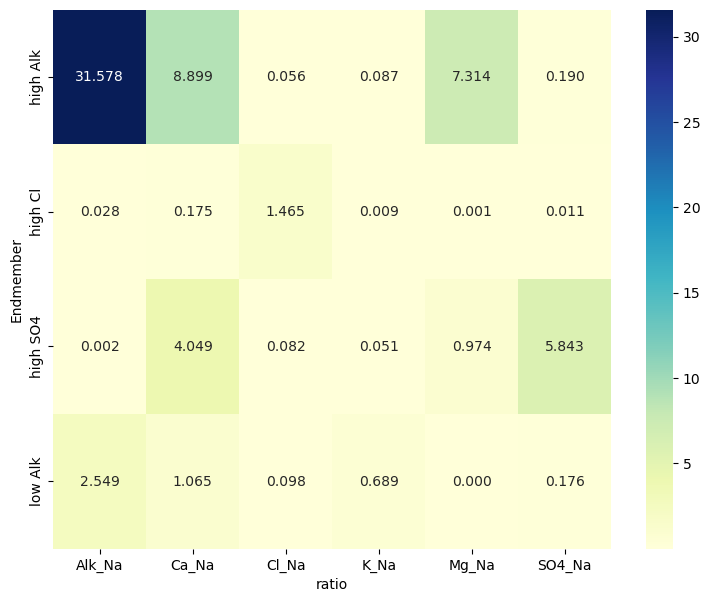

In [14]:
# Creating heatmap
heatmap_endmember = endmember_mean_composition.melt(id_vars='Endmember', var_name='ratio', value_name='value')
plt.figure(figsize=(9, 7))
heatmap = sns.heatmap(heatmap_endmember.pivot(index='Endmember', columns='ratio', values='value'), cmap="YlGnBu", annot=True, fmt=".3f")
plt.savefig("../output/figures/heatmap_endmember_4em_na.pdf")
plt.show()

### 4.2 Plot histogram of proportion (in terms of Na) of each end-member to each sample

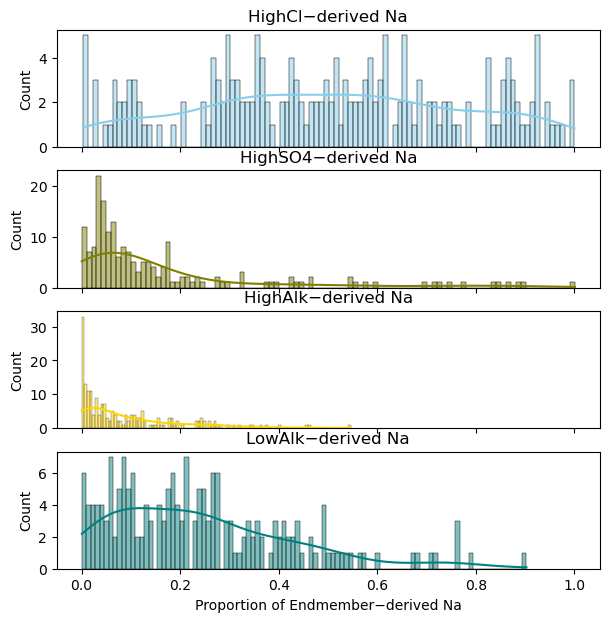

In [15]:
X_Na = us_annual_nmf_clean_na.assign(Na_cl=us_annual_nmf_clean_na['X_cl'],
                                     Na_so4=us_annual_nmf_clean_na['X_so4'],
                                     Na_high_alk=us_annual_nmf_clean_na['X_high_alk'],
                                     Na_low_alk=us_annual_nmf_clean_na['X_low_alk'])

# Plotting using Seaborn
fig, axs = plt.subplots(4, sharex=True, sharey=False, figsize=(7, 7))
sns.histplot(data=X_Na, x="Na_cl", bins=100, kde=True, color="skyblue",ax=axs[0]).set(title="HighCl−derived Na")
sns.histplot(data=X_Na, x="Na_so4", bins=100, kde=True, color="olive",ax=axs[1]).set(title="HighSO4−derived Na")
sns.histplot(data=X_Na, x="Na_high_alk", bins=100, kde=True, color="gold",ax=axs[2]).set(title="HighAlk−derived Na")
sns.histplot(data=X_Na, x="Na_low_alk", bins=100, kde=True, color="teal",ax=axs[3]).set(title="LowAlk−derived Na")

plt.xlabel("Proportion of Endmember−derived Na")
plt.savefig("../output/figures/NMF_4em_Na_10percent-error.pdf")
plt.show()

### 4.3 Plot maps showing contribution of each endmember

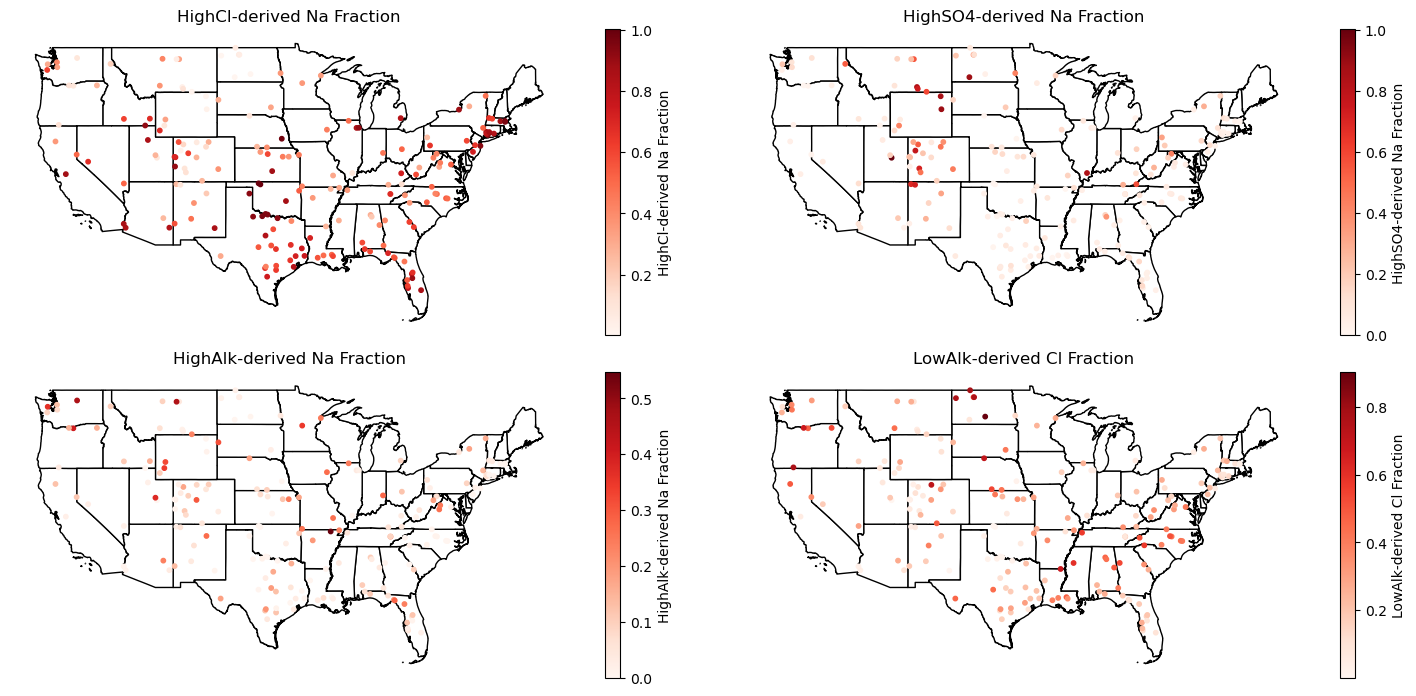

In [16]:
# Read the sampling locations
us_annual_nmf_location = gpd.GeoDataFrame(
    us_annual_nmf_clean_na, 
    geometry=gpd.points_from_xy(us_annual_nmf_clean_na["dec_lon_va"], us_annual_nmf_clean_na["dec_lat_va"]), 
    crs="EPSG:4326"
)

# Create separate plots for each endmember contribution
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))

maps = [
    ("X_cl", "HighCl-derived Na Fraction"),
    ("X_so4", "HighSO4-derived Na Fraction"),
    ("X_high_alk", "HighAlk-derived Na Fraction"),
    ("X_low_alk", "LowAlk-derived Cl Fraction")
]

for i, (col, title) in enumerate(maps):
    ax = axs[i // 2, i % 2]
    us_states_filtered.plot(ax=ax, color='white', edgecolor='black', linestyle='-', linewidth=1)
    us_annual_nmf_location.plot(ax=ax, column=col, cmap='Reds', markersize=10,
                                 legend=True, legend_kwds={'label': title})
    ax.set_title(title)
    ax.set_axis_off()

plt.tight_layout()
plt.savefig("../output/figures/Na_Endmember_Contribution_Map.pdf")
plt.show()